# Zebra page separation A/B Test Analysis report 6: 
# Deepdive metrics by viewportSizeBucket
__Jennifer Wang, Staff Data Scientist, Wikimedia Foundation__

July 2023

## TICKETS:
Instumentation planning : 
- Spec: [T333222](https://phabricator.wikimedia.org/T333222)

Instrumentation deployment :  
- Launch AB test: [T335972](https://phabricator.wikimedia.org/T335972)
- Fix bug: [T336969](https://phabricator.wikimedia.org/T336969) [T337955](https://phabricator.wikimedia.org/T337955)

Data tickets:
- Data QA: [T336299](https://phabricator.wikimedia.org/T336299)
- __Analysis: [T335379](https://phabricator.wikimedia.org/T335379)__

# Introduction

The Wikimedia Foundation's Web team is exploring a new page separation in vector-2022 skin. The current Vector 2022 interface uses whitespace to separate the various regions and has a white page background. The proposed new page interface uses gray background  to separate the various regions. The team hope the new layout separation will help users focus on the content and reduce the eye strain experienced by some individuals.  

To evaluate the impact of introducing the new page separation , an AB test was conducted on the desktop logged-in users with vector-2022 skin between May 29,2023 and Jun 20, 2023. The experiment only took place on the following test wikis:  hewiki, enwiki, fawiki, frwiki, kowiki, ptwiki, srwiki, thwiki, trwiki, viwiki.


__The default Vector-2022 layout with a white background__    
<img src="Figures/default_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />    
__The new layout (Zebra) with a gray background outside of the content area__.     
<img src="Figures/zebra_layout.png" width="800" height="600" align="center" style="border: 5px solid LightSteelBlue" />     

# Purpose

The primary goal of the AB Test was to test two hypothesis:
1. There is no significant change on pageviews with the new layout separation.
2. There is no significant change on edits with the new layout separation.

We also sought to answer three curiosity questions:
1. Does it impact the usage of TOC as the new layout separated ToC and content into different boxes?
2. Does it impact the usage of Page tools? (Number of pins or unpins)
3. Does it impact the scrolling to top behavior? (Nice to have)

This report focuses on the above metrics __broken down by viewportSizeBucket__.

# Methodology

The AB test was run on a per wiki basis on logged-in users with Vector-2022 skin. Users included in the test were randomly assigned to either the control (default) or treatment (new page separation) based on their local user ID.

We reviewed AB test data recorded from 02 Jun 2023 through 19 Jun 2023 for this analysis. Data was limited to pageviews and edits completed by desktop logged-in users who were selected in the AB test.

We compared the numbers of each metric between control and treatment groups broken down by viewportSizeBucket.

Note that we excluded data collected from May 29 2023  to June 1 2023 in this analysis due to a bug which caused the edit button to be missing on the sticky header.

In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [2]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [7]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Analysis
## Pageviews By viewportSizeBucket


As discovered in QA [T336299](https://phabricator.wikimedia.org/T336299), we should 
1) exclude sessions which were assigned to both control group and treatment group. They constitute 0.12% of total sessions. 
2) exclude 466 sessions from bot users.

In [8]:
query_pageviews <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- pageviews from ab test group
SELECT  t3.event.token AS session_id, t3.event.pageToken AS page_token, 
t3.wiki, t3.event.editCountBucket,  t4.test_group, 
event.viewportSizeBucket AS view_size,
count(1) AS pvs
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='init' AND event.skin='vector-2022'
GROUP BY  t3.event.token ,t3.event.pageToken, t3.wiki, t3.event.editCountBucket,  
t4.test_group , event.viewportSizeBucket
"

In [9]:
df_pageviews <- wmfdata::query_hive(query_pageviews)

Don't forget to authenticate with Kerberos using kinit



In [10]:
dim(df_pageviews)

[1] 19921367        7

In [12]:
df_pvs_viewsize_per_session <- df_pageviews %>%
   group_by(wiki,test_group, session_id, view_size) %>%
   summarize(sum_pvs=sum(pvs),n_pages=n_distinct(page_token), .groups='drop')

In [14]:
dim(df_pvs_viewsize_per_session)

[1] 1189604       6

In [167]:
summary(df_pvs_viewsize_per_session)

     wiki            test_group         session_id       
 Length:1189604     Length:1189604     Length:1189604    
 Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character  
                                                         
                                                         
                                                         
         view_size         sum_pvs            n_pages        
 <320px       :  1817   Min.   :    1.00   Min.   :    1.00  
 320px-719px  : 20484   1st Qu.:    1.00   1st Qu.:    1.00  
 720px-999px  : 74490   Median :    3.00   Median :    3.00  
 1000px-1199px:162054   Mean   :   16.75   Mean   :   16.75  
 1200px-2000px:879537   3rd Qu.:   10.00   3rd Qu.:   10.00  
 >2000px      : 51222   Max.   :30938.00   Max.   :30938.00  

In [17]:
df_pvs_viewsize_per_session %>% 
  group_by(session_id) %>%
  summarize(n_dup=n_distinct(view_size), .groups='drop') %>%
  filter(n_dup>1) %>% 
  nrow()

[1] 70402

In [1]:
70402/1106811

[1] 0.06360797

### Note
70402 sessions (6% of total sessions) switched view port size bucket groups during AB test. 

In [21]:
df_pvs_viewsizebucket_overall <- df_pvs_viewsize_per_session %>%
   group_by(test_group, view_size ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(pvs_per_sessions = round(total_pvs/n_sessions,2))

In [26]:
df_pvs_viewsizebucket_overall$view_size <- factor(df_pvs_viewsizebucket_overall$view_size,
        levels=c("<320px","320px-719px","720px-999px","1000px-1199px","1200px-2000px",">2000px"))
                                                  

In [27]:
df_pvs_viewsizebucket_overall

test_group,view_size,total_pvs,total_pv_pages,n_sessions,pvs_per_sessions
<chr>,<fct>,<int>,<int>,<int>,<dbl>
control,1000px-1199px,1155513,1155264,81941,14.10
control,1200px-2000px,7931416,7930399,454806,17.44
control,320px-719px,91845,91821,10173,9.03
control,720px-999px,500164,500036,37734,13.25
control,<320px,1948,1948,887,2.20
control,>2000px,375203,375164,25852,14.51
treatment,1000px-1199px,1019384,1019157,80113,12.72
treatment,1200px-2000px,7858550,7857686,424731,18.50
treatment,320px-719px,81331,81296,10311,7.89


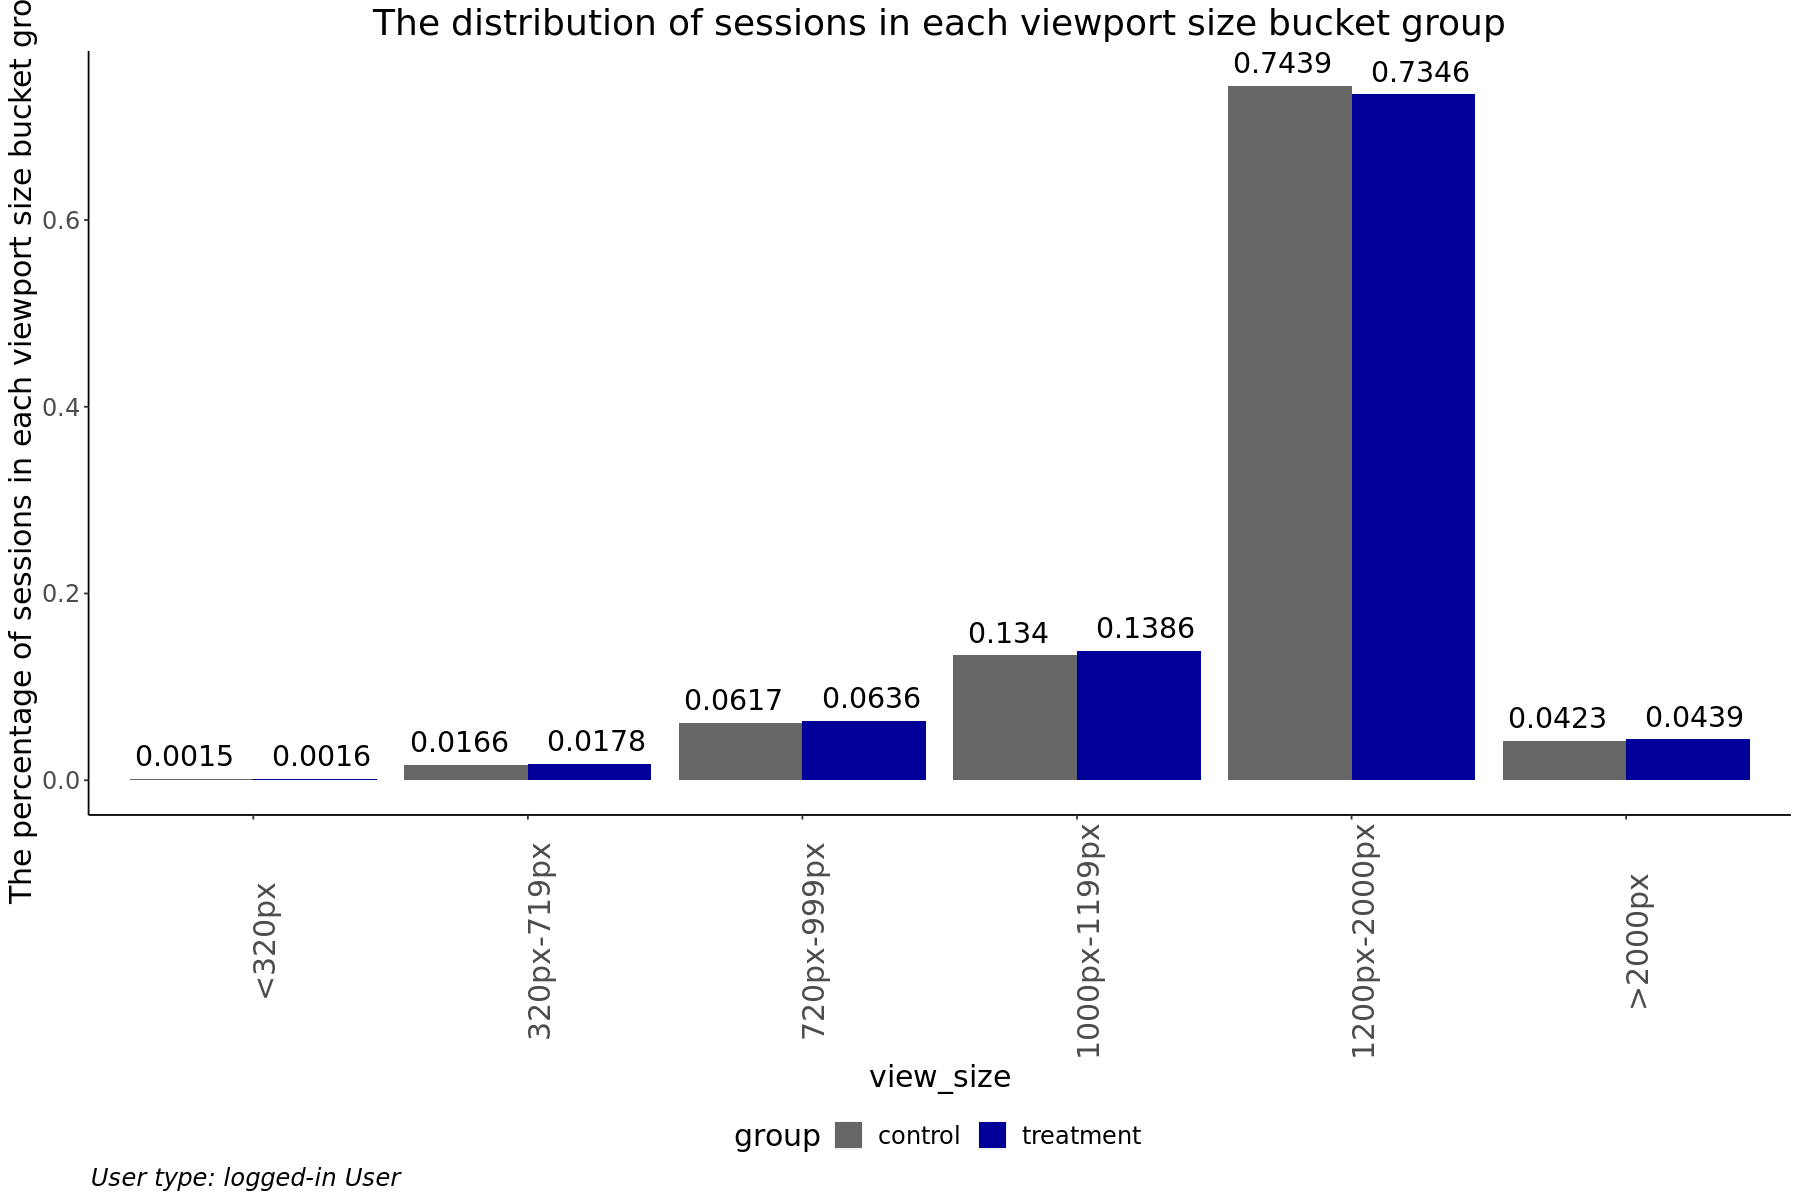

In [33]:
barchart_sessions_viewsizebucket_overall <- df_pvs_viewsizebucket_overall %>%
  group_by(test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),4)
      ) %>% 
  ggplot(aes(x = view_size, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(ptg)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.6, hjust = 0.5, size = 6) +
        labs (
              y = "The percentage of sessions in each viewport size bucket group" ,
             title = "The distribution of sessions in each viewport size bucket group" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_viewsizebucket_overall

### Note 

Generally, majority of users use devices with 1200px-2000px

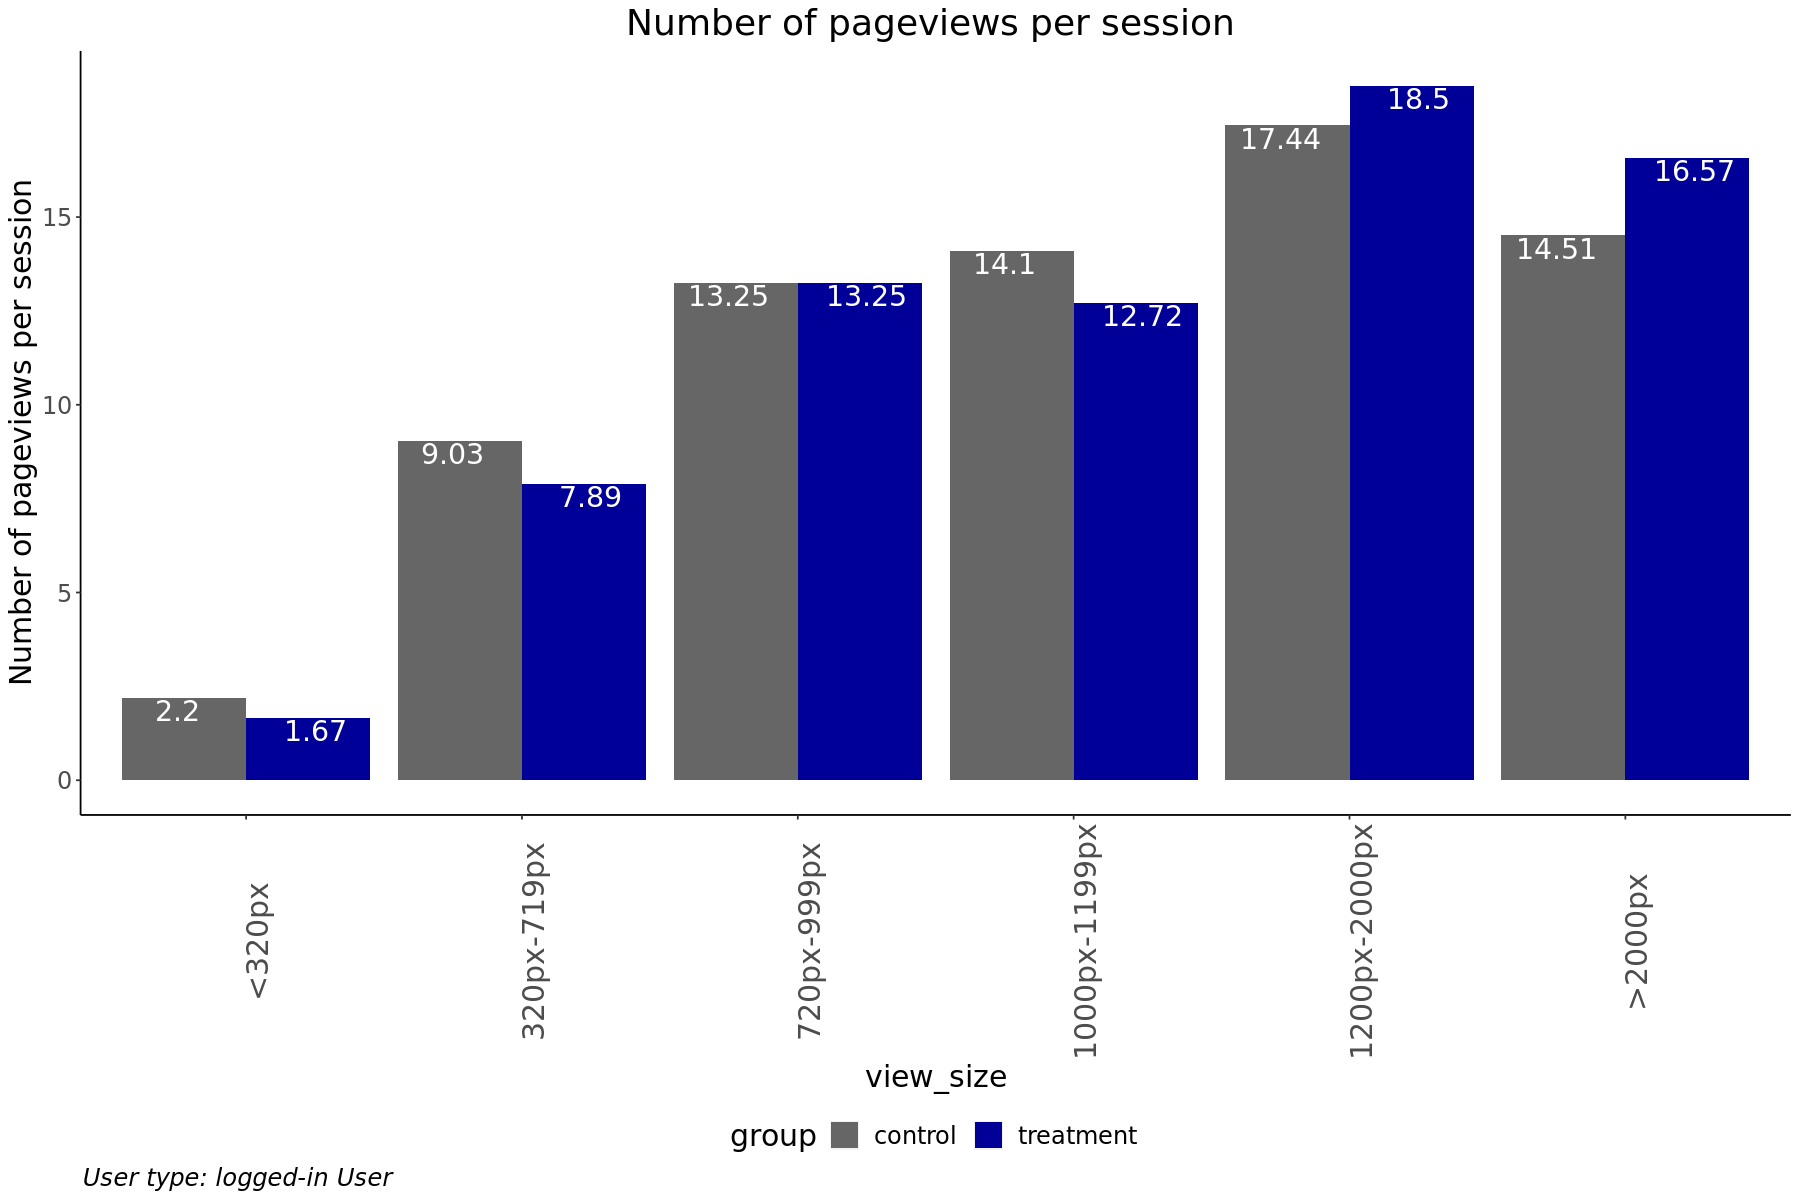

In [30]:
barchart_pvs_viewportsizebucket_overall  <- df_pvs_viewsizebucket_overall  %>%
        select(view_size, test_group, pvs_per_sessions) %>%
        ggplot(aes(x = view_size, y= pvs_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(pvs_per_sessions)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 6) +
        labs (
              y = "Number of pageviews per session" ,
             title = "Number of pageviews per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pvs_viewportsizebucket_overall

### Note 

When broken down by the viewport size bucket, we observed that the treatment group exhibited an increase in page views per session in large viewport devices: 1200px-2000px, >2000px. 

In [35]:
df_pvs_wiki_viewsizebucket <- df_pvs_viewsize_per_session %>%
   group_by(wiki,test_group, view_size ) %>%
   summarize(total_pvs=sum(sum_pvs),total_pv_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop')

In [36]:
df_pvs_wiki_viewsizebucket  <- df_pvs_wiki_viewsizebucket  %>%
  mutate(pvs_per_sessions = round(total_pvs/n_sessions,2))


In [38]:
df_pvs_wiki_viewsizebucket$view_size <- factor(df_pvs_wiki_viewsizebucket$view_size,
        levels=c("<320px","320px-719px","720px-999px","1000px-1199px","1200px-2000px",">2000px"))

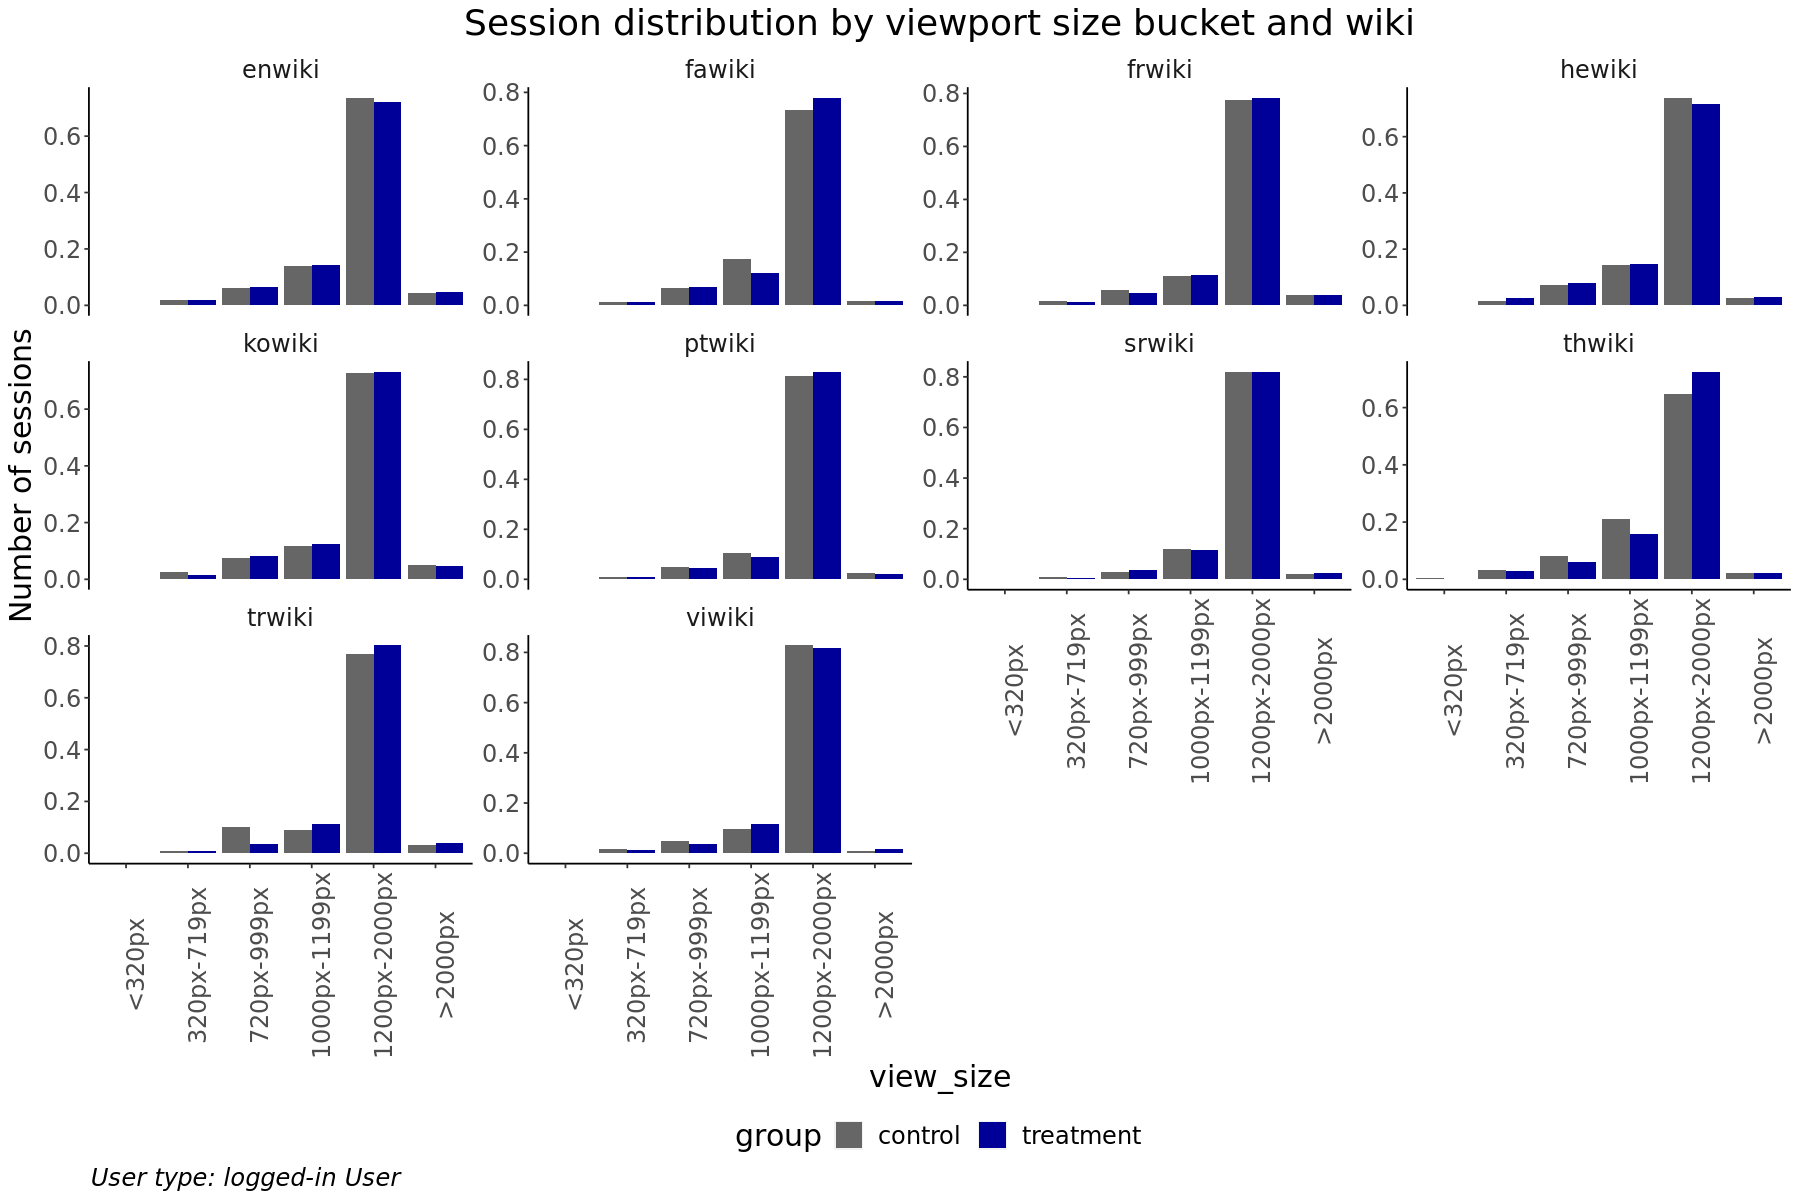

In [41]:
barchart_sessions_viewsizebucket <- df_pvs_wiki_viewsizebucket  %>%
  group_by(wiki,test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),4)
      ) %>%
 ggplot(aes(x = view_size, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of sessions" ,
             title = "Session distribution by viewport size bucket and wiki" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_viewsizebucket
      

### Note 
For each individual wiki, the distribution of sessions by viewport size bucket are similar.

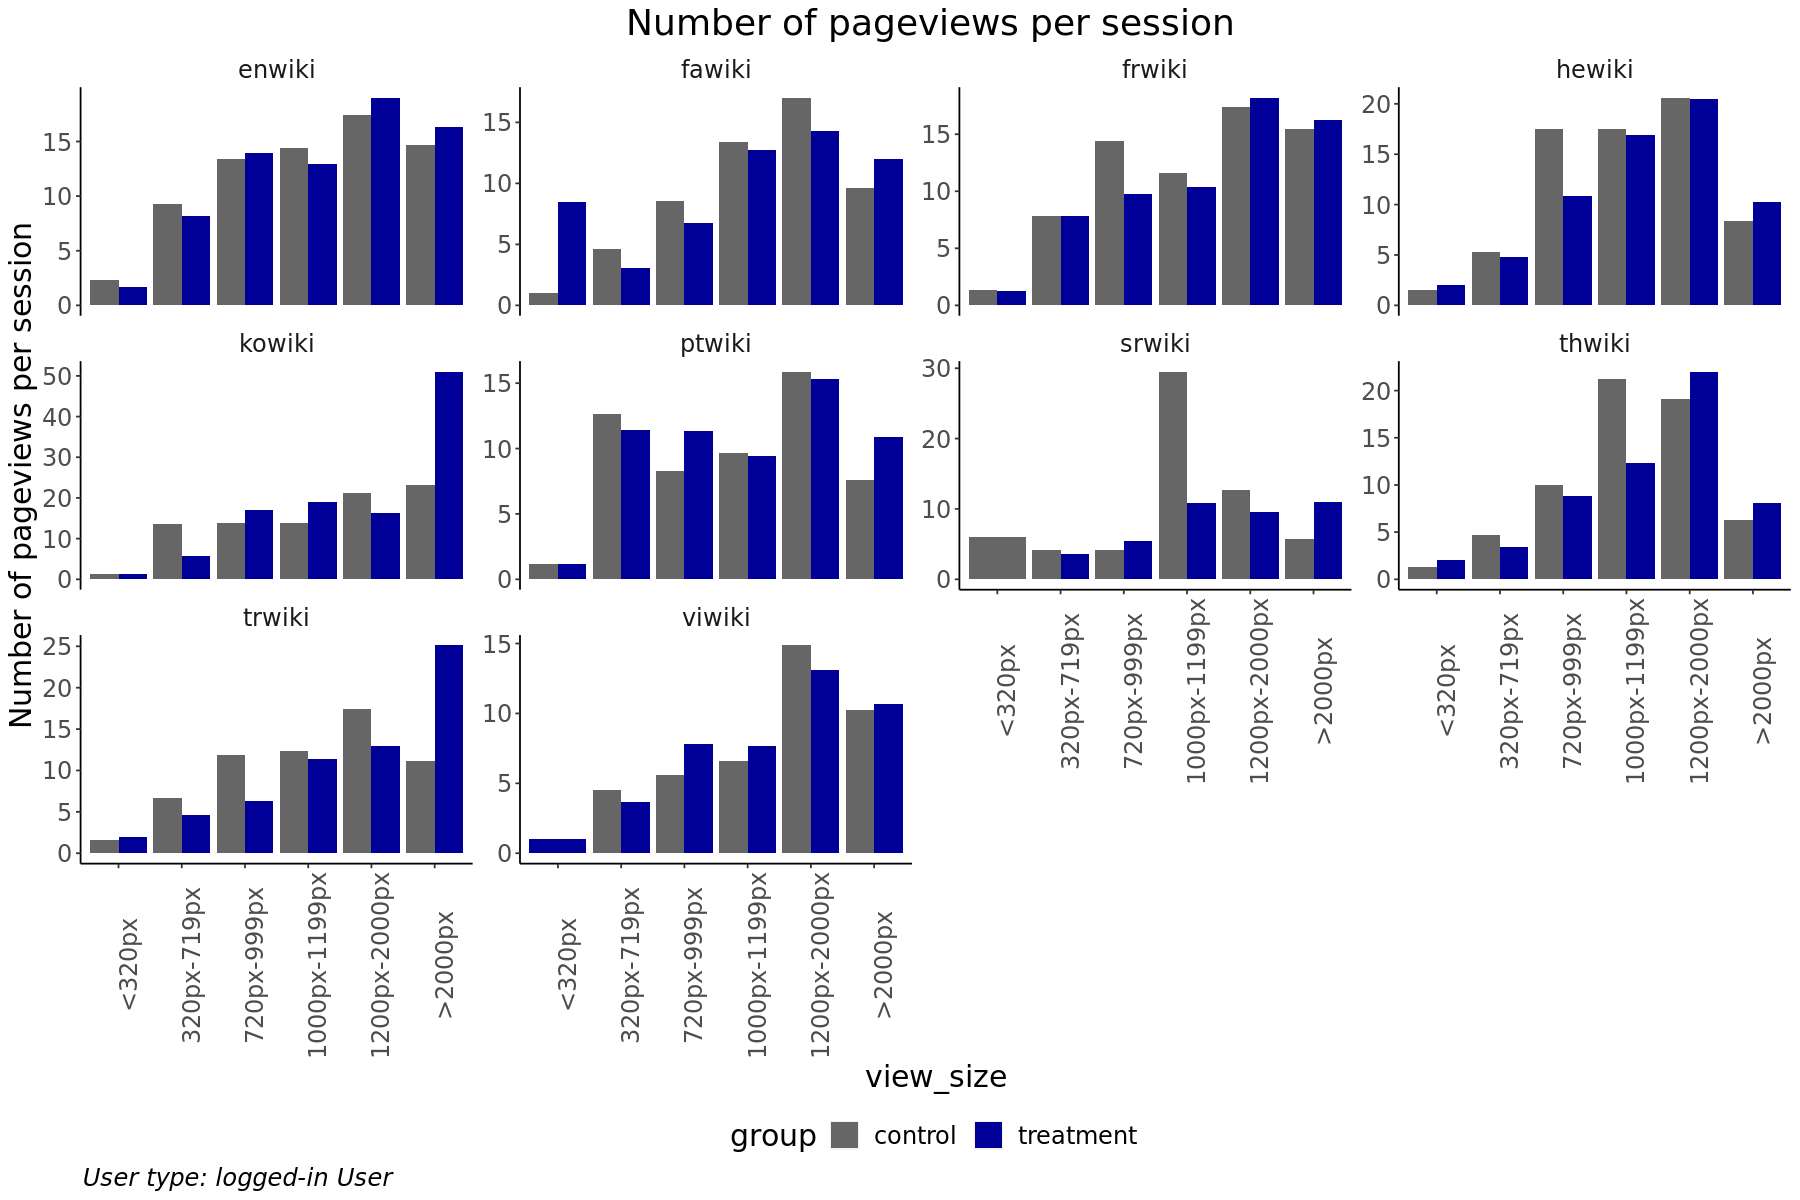

In [43]:
barchart_pvs_viewsize  <- df_pvs_wiki_viewsizebucket   %>%
        select(wiki, test_group,view_size, pvs_per_sessions) %>%
        ggplot(aes(x = view_size, y= pvs_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of pageviews per session" ,
             title = "Number of pageviews per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pvs_viewsize

### Note 
Across all wiki, pageviews increased in the ‘>2000px’ viewport size bucket.

## Edits (clicks on edit button) by viewportSizeBucket

In [46]:
query_edit_clicks <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 AND month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')  
AND year=2023  and month=6
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_bot
AND NOT is_anon
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks on edit button from ab test group
SELECT  t3.event.token AS session_id, t3.event.pageToken AS page_token,
t3.wiki,   t4.test_group,  t3.event.viewportSizeBucket as view_size,
count(1) AS edit_clicks
FROM event.desktopwebuiactionstracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND NOT event.isanon 
AND event.action='click' 
AND event.name IN ('ca-edit','ca-ve-edit')
AND event.skin='vector-2022'
GROUP BY  t3.event.token ,  t3.event.pageToken,  t3.wiki, t4.test_group , t3.event.viewportSizeBucket
"


In [47]:
df_edit_clicks <- wmfdata::query_hive(query_edit_clicks)

Don't forget to authenticate with Kerberos using kinit



In [50]:
df_edits_viewsize_per_session <- df_edit_clicks  %>%
   group_by(wiki,test_group, session_id, view_size) %>%
   summarize(sum_edits=sum(edit_clicks),n_pages=n_distinct(page_token), .groups='drop')

In [55]:
df_edits_viewsize_per_session$view_size <- factor(df_edits_viewsize_per_session$view_size,
        levels=c("<320px","320px-719px","720px-999px","1000px-1199px","1200px-2000px",">2000px"))

In [58]:
df_edits_viewsizebucket_overall <- df_edits_viewsize_per_session %>%
   group_by(test_group, view_size ) %>%
   summarize(total_edits=sum(sum_edits),total_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(edits_per_sessions = round(total_edits/n_sessions,2))

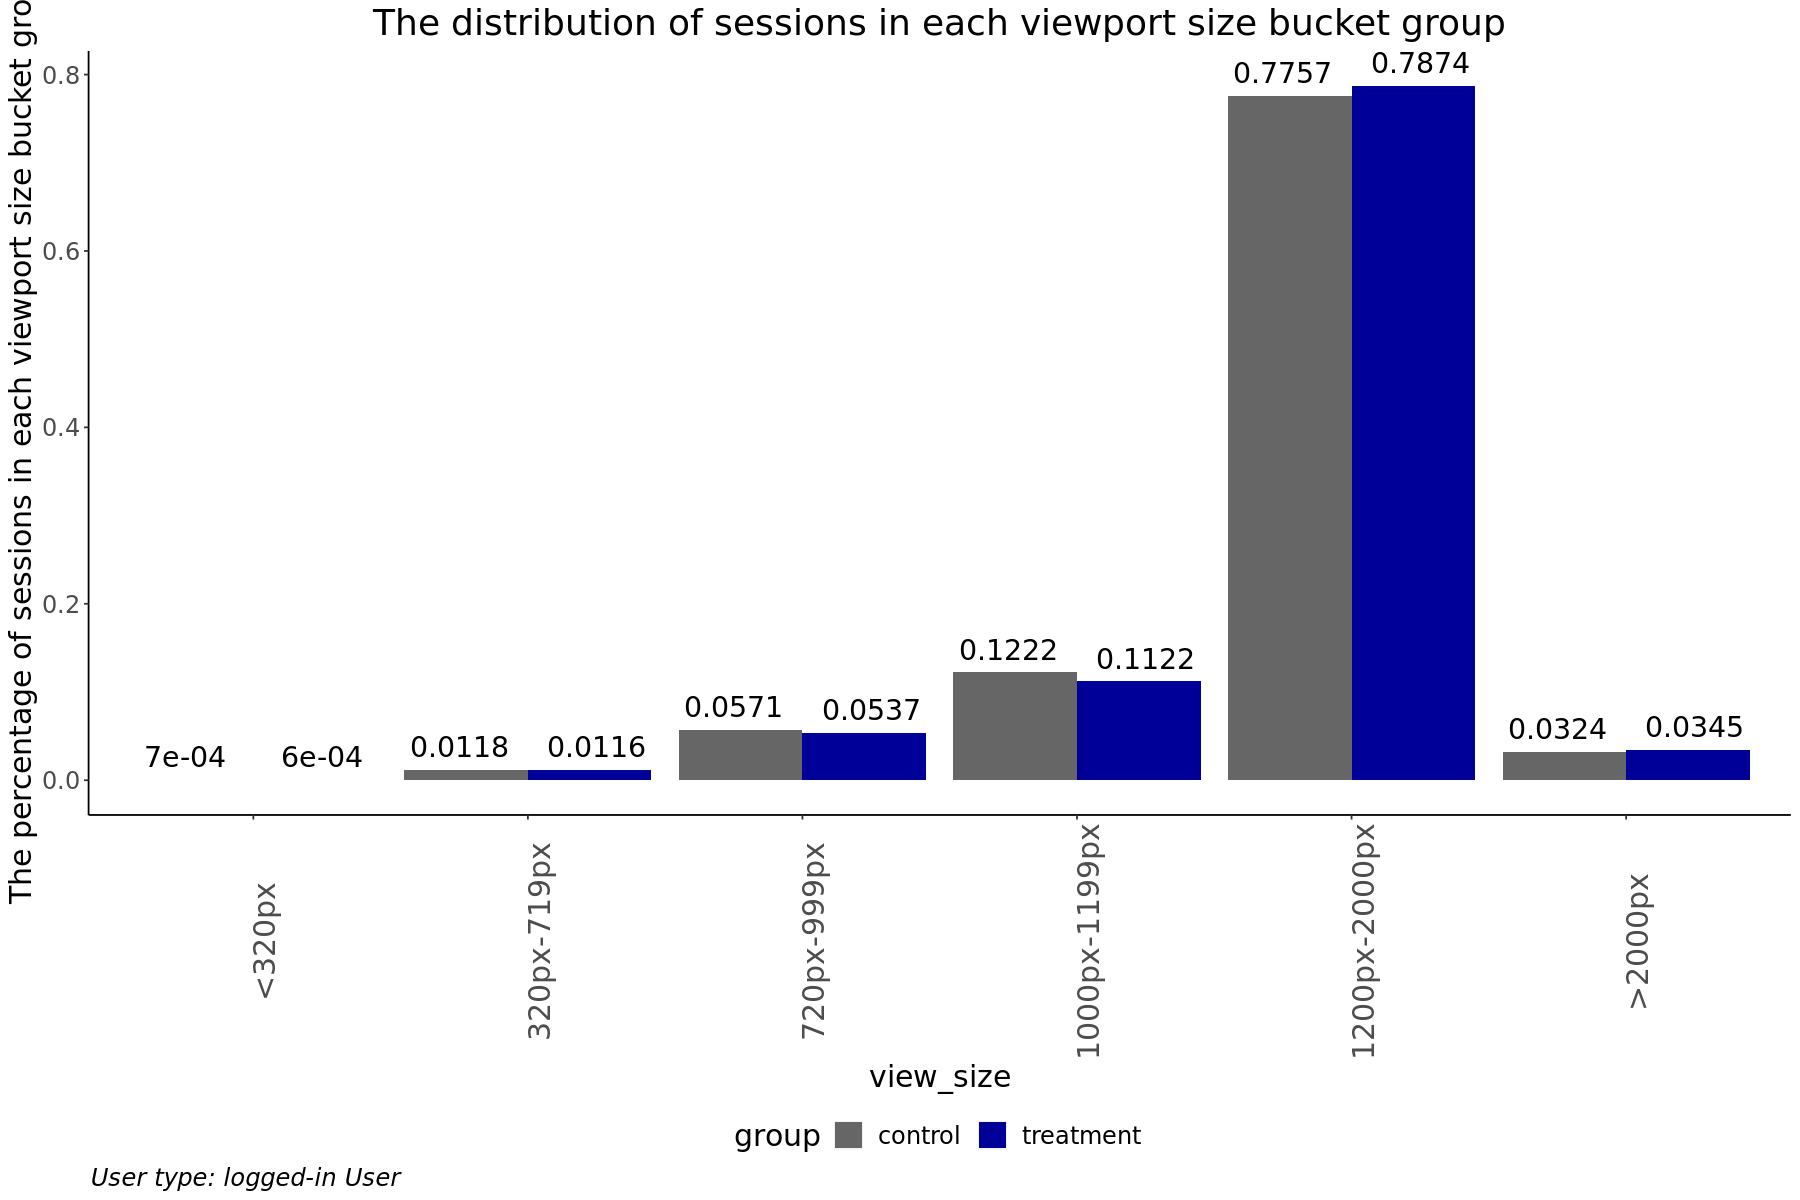

In [60]:
barchart_sessions_viewsizebucket_overall <- df_edits_viewsizebucket_overall  %>%
  group_by(test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),4)
      ) %>% 
  ggplot(aes(x = view_size, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(ptg)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.6, hjust = 0.5, size = 6) +
        labs (
              y = "The percentage of sessions in each viewport size bucket group" ,
             title = "The distribution of sessions in each viewport size bucket group" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_viewsizebucket_overall

### Note

Majority of editors use devices with 1200px-2000px viewport

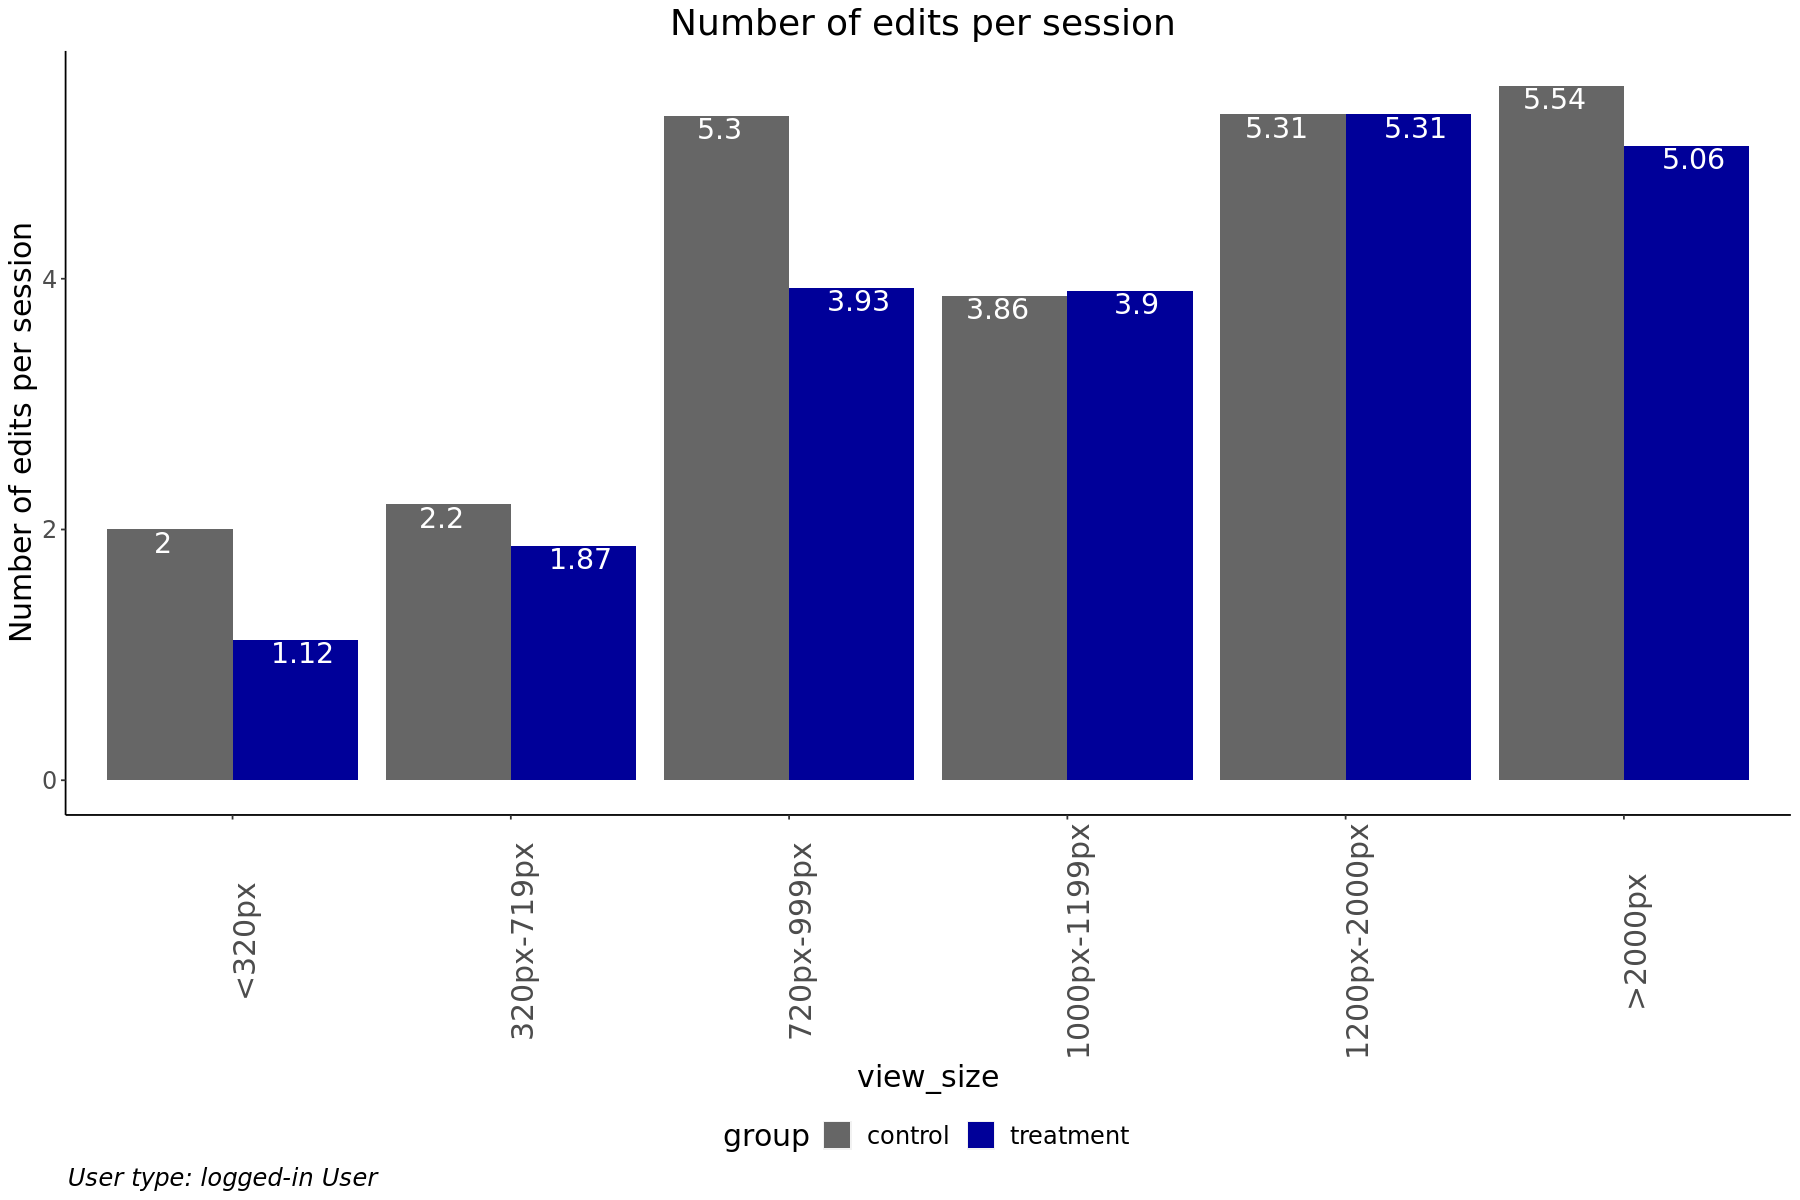

In [63]:
barchart_edits_viewportsizebucket_overall  <- df_edits_viewsizebucket_overall   %>%
        select(view_size, test_group, edits_per_sessions) %>%
        ggplot(aes(x = view_size, y= edits_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(edits_per_sessions)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 6) +
        labs (
              y = "Number of edits per session" ,
             title = "Number of edits per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_edits_viewportsizebucket_overall

### Note


Edits per session decreased significantly on devices with smaller viewport.

## ToC clicks

In [66]:
query_click_toc <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE  t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_anon
AND NOT is_bot
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.event.token AS session_id, 
wiki, event.isanon,  t4.test_group, event.name, t3.event.viewportSizeBucket AS view_size, 
t3.event.pageToken,  count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND event.name IN (  'ui.sidebar-toc' , 'toc-heading.toc-pinned-disabled', 'toc-heading.toc-pinned-enabled')
AND event.action='click' 
AND event.skin='vector-2022'
-- exclude anonymous users, some sessions swtich between loggin mode and loggout mode.
AND NOT event.isanon
GROUP BY t3.event.token, t3.wiki, event.isanon, t4.test_group, event.name, t3.event.viewportSizeBucket, t3.event.pageToken
"

In [67]:
df_toc <- wmfdata::query_hive(query_click_toc)

Don't forget to authenticate with Kerberos using kinit



In [83]:
df_toc_click_viewsize_per_session <- df_toc   %>%
   group_by(wiki,test_group, session_id, name, view_size) %>%
   summarize(sum_toc_clicks=sum(clicks),n_pages=n_distinct(pagetoken), .groups='drop')

In [84]:
df_toc_click_viewsize_per_session$view_size <- factor(df_toc_click_viewsize_per_session$view_size,
        levels=c("<320px","320px-719px","720px-999px","1000px-1199px","1200px-2000px",">2000px"))

In [90]:
df_toc_click_viewsizebucket_overall <- df_toc_click_viewsize_per_session %>%
   group_by(test_group, view_size ) %>%
   summarize(total_toc_clicks=sum(sum_toc_clicks),total_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(toc_clicks_per_sessions = round(total_toc_clicks/n_sessions,2))

In [91]:
df_toc_click_viewsizebucket_overall

test_group,view_size,total_toc_clicks,total_pages,n_sessions,toc_clicks_per_sessions
<chr>,<fct>,<int>,<int>,<int>,<dbl>
control,<320px,369,283,170,2.17
control,320px-719px,4096,3219,1432,2.86
control,720px-999px,6780,5505,2259,3.00
control,1000px-1199px,81298,48189,13774,5.90
control,1200px-2000px,514794,303070,79313,6.49
control,>2000px,19140,11972,4362,4.39
treatment,<320px,270,210,160,1.69
treatment,320px-719px,4670,3715,1513,3.09
treatment,720px-999px,8062,6761,2043,3.95


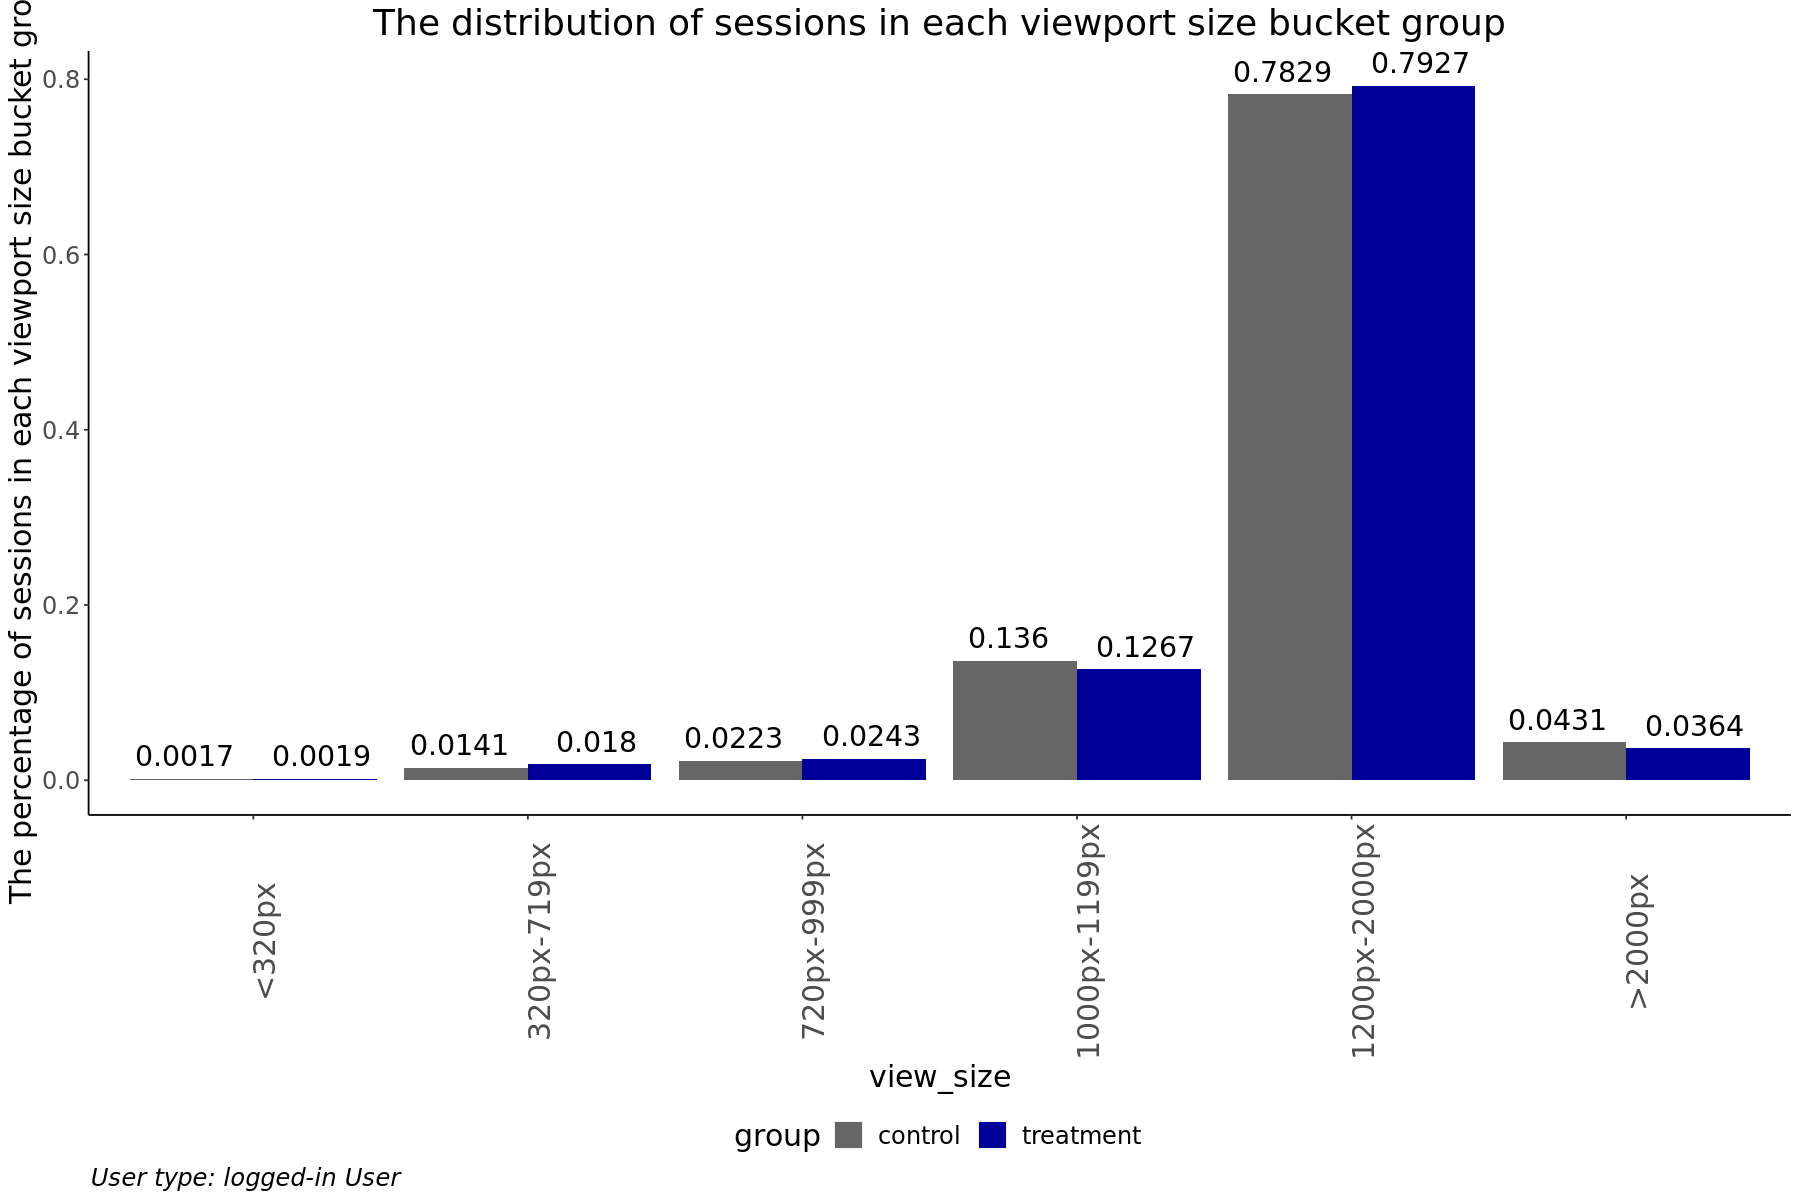

In [92]:
barchart_sessions_viewsizebucket_overall <- df_toc_click_viewsizebucket_overall  %>%
  group_by(test_group) %>%
  mutate(
      ptg=round(n_sessions/sum(n_sessions),4)
      ) %>% 
  ggplot(aes(x = view_size, y= ptg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(ptg)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.6, hjust = 0.5, size = 6) +
        labs (
              y = "The percentage of sessions in each viewport size bucket group" ,
             title = "The distribution of sessions in each viewport size bucket group" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_viewsizebucket_overall

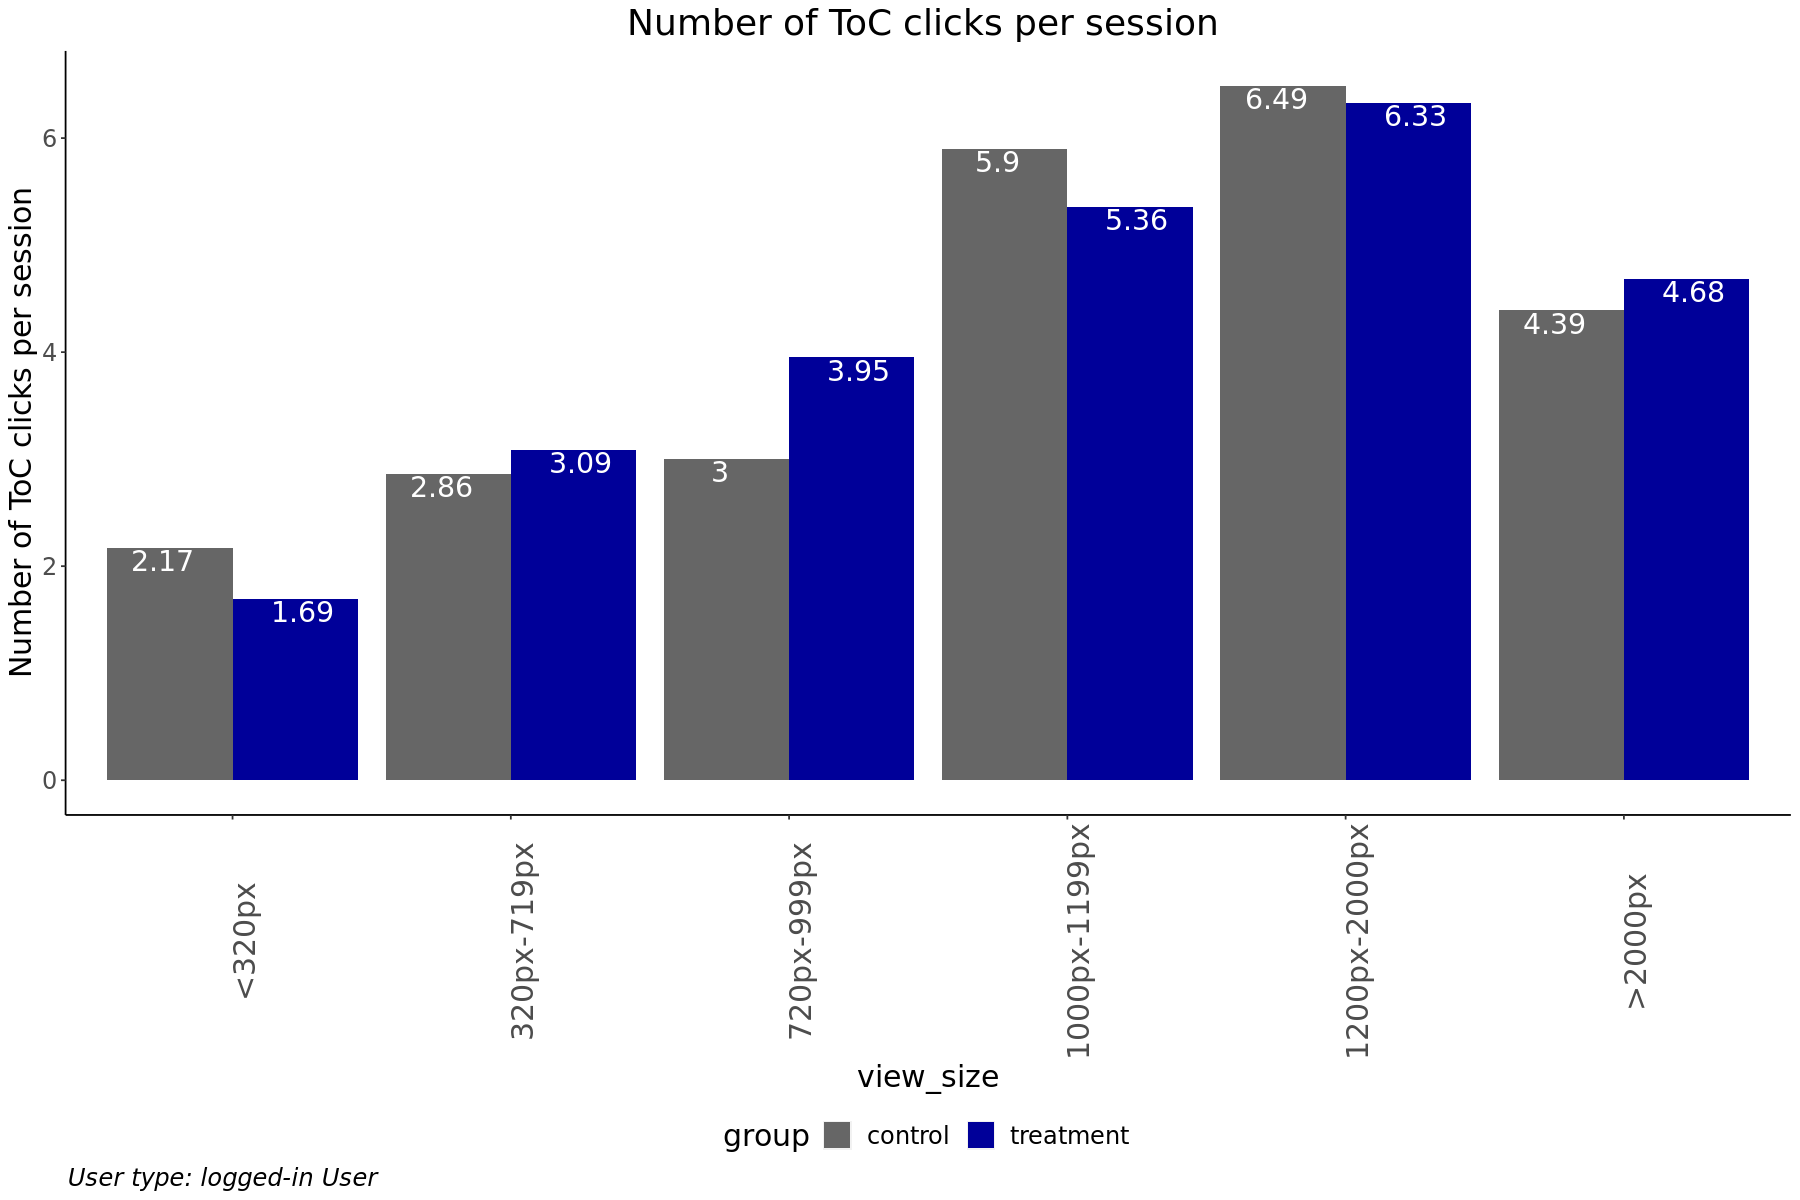

In [82]:
barchart_toc_clicks_viewportsizebucket_overall  <- df_toc_click_viewsizebucket_overall   %>%
        select(view_size, test_group, toc_clicks_per_sessions) %>%
        ggplot(aes(x = view_size, y= toc_clicks_per_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(toc_clicks_per_sessions)), color = "white", position = position_dodge(width = 1), 
                  vjust = 1.1, hjust = 0.5, size = 6) +
        labs (
              y = "Number of ToC clicks per session" ,
             title = "Number of ToC clicks per session " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_toc_clicks_viewportsizebucket_overall

#### By ToC scenario

In [93]:
df_toc_click_viewsizebucket_type <- df_toc_click_viewsize_per_session %>%
   group_by(test_group, name,view_size ) %>%
   summarize(total_toc_clicks=sum(sum_toc_clicks),total_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(toc_clicks_per_sessions = round(total_toc_clicks/n_sessions,2))

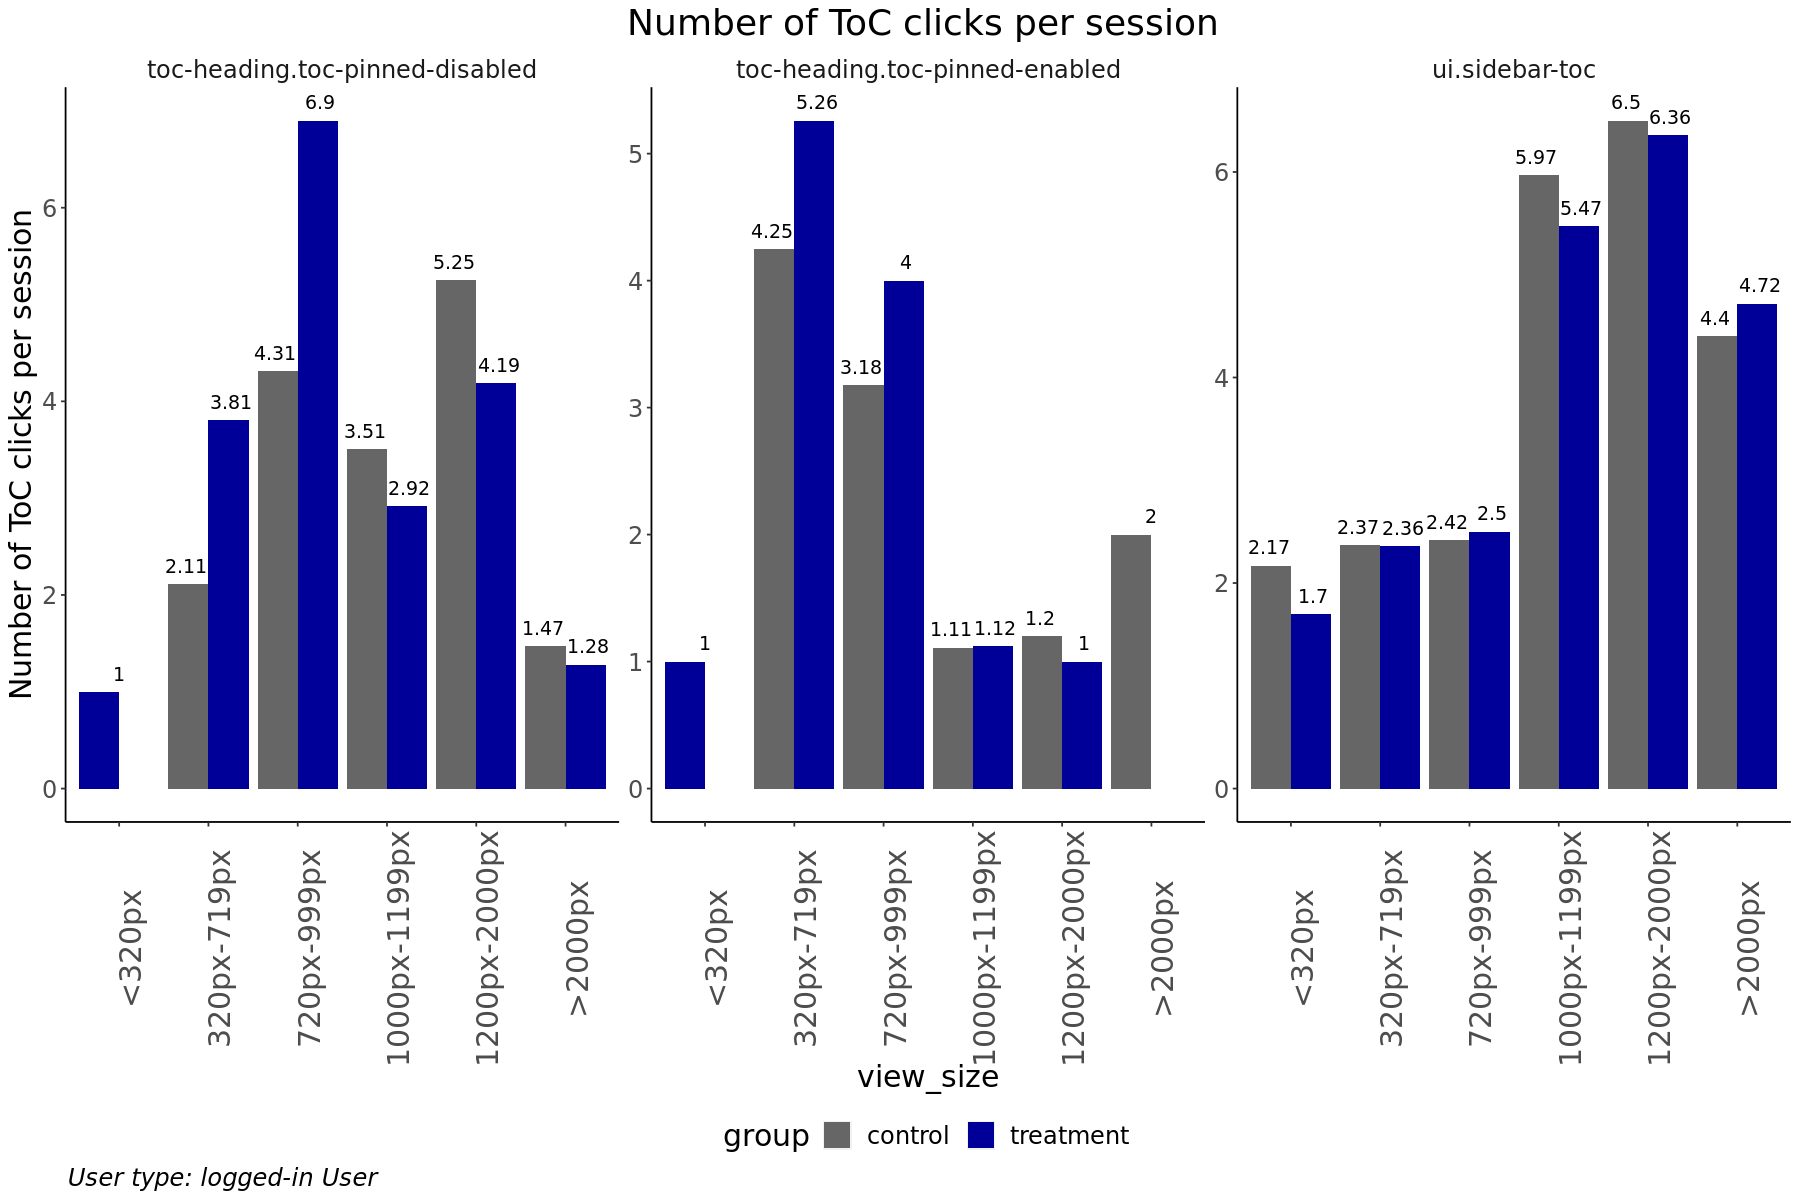

In [109]:
barchart_toc_clicks_viewportsizebucket_type  <- df_toc_click_viewsizebucket_type  %>%
        select(view_size,name, test_group, toc_clicks_per_sessions) %>%
        ggplot(aes(x =view_size , y= toc_clicks_per_sessions, fill=test_group)) +
        geom_col( position = position_dodge(preserve = "single") ) +  
        facet_wrap(~name, scale = 'free_y') +
        scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
        geom_text(aes(label = paste(toc_clicks_per_sessions)), color = "black", 
                  position = position_dodge(width = 1), 
                  vjust = -0.8, hjust = 0.5, size =4) +
        labs (
              y = "Number of ToC clicks per session" ,
             title = "Number of ToC clicks per session " ,
             caption = "User type: logged-in User" ) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_toc_clicks_viewportsizebucket_type

### Note

ToC clicks on `toc-heading.toc-pinned-enabled` and `toc-heading.toc-pinned-disabled` increased significantly on smaller viewport buckets:  <320px, 300px-719px, 720px-999px. 

ToC clicks on `ui.sidebar-toc` are mostly from larger viewport size bucket, increased on large viewport buckets:   >2000px. 

## Pagetool pin and unpin

In [123]:
query_pagetool <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') and year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE  t1.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki') 
AND year=2023 and month = 6 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND  experiment_name='skin-vector-zebra-experiment'
AND NOT is_anon
AND NOT is_bot
AND skin='vector-2022'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT t3.event.token AS session_id, 
wiki, event.isanon,  t4.test_group, event.name, t3.event.viewportSizeBucket AS view_size, t3.event.pageToken,  count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('hewiki', 'enwiki', 'fawiki', 'frwiki', 'kowiki', 'ptwiki', 'srwiki', 
'thwiki', 'trwiki', 'viwiki')
AND t3.year=2023 and t3.month=6
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2023-06-02' AND '2023-06-19'
AND t4.session_dt <= t3.meta.dt
AND event.name IN (
-- To pin the page tool to the right sidebar
'pinnable-header.vector-page-tools.pin' ,
-- To unpin the page tool
 'pinnable-header.vector-page-tools.unpin'
)
AND event.action='click' AND event.skin='vector-2022'
-- exclude anonymous users, some sessions swtich between loggin mode and loggout mode.
AND NOT event.isanon
GROUP BY t3.event.token, t3.wiki, event.isanon, t4.test_group, event.name, t3.event.viewportSizeBucket, t3.event.pageToken
"

In [135]:
df_pagetool <- wmfdata::query_hive(query_pagetool)

Don't forget to authenticate with Kerberos using kinit



In [137]:
df_pagetool_W <- df_pagetool %>%
  mutate(action=case_when(
           name=='pinnable-header.vector-page-tools.unpin' ~ 'unpins',
           name=='pinnable-header.vector-page-tools.pin' ~ 'pins'
           )
         ) %>%
  select(session_id,wiki,isanon,test_group,action, view_size, pagetoken,clicks ) %>%
  spread(key=action, value=clicks, fill=0)

In [139]:
summary(df_pagetool_W)

  session_id            wiki              isanon           test_group       
 Length:5936        Length:5936        Length:5936        Length:5936       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  view_size          pagetoken              pins            unpins      
 Length:5936        Length:5936        Min.   :0.0000   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:0.0000   1st Qu.:1.0000  
 Mode  :character   Mode  :character   Median :0.0000   Median :1.0000  
                                       Mean   :0.1693   Mean   :0.9821  
                                       3rd Qu.:0.0000   3rd Qu.:1.0000  
                       

In [145]:
df_pagetool_W$view_size <- factor(df_pagetool_W$view_size,
        levels=c("<320px","320px-719px","720px-999px","1000px-1199px","1200px-2000px",">2000px"))

In [146]:
df_pt_viewsize_per_session <- df_pagetool_W  %>%
   group_by(wiki,test_group, session_id, view_size) %>%
   summarize(sum_pins=sum(pins),sum_unpins=sum(unpins), n_pages=n_distinct(pagetoken), .groups='drop')

In [147]:
summary(df_pt_viewsize_per_session)

     wiki            test_group         session_id                view_size   
 Length:5495        Length:5495        Length:5495        <320px       :   0  
 Class :character   Class :character   Class :character   320px-719px  :  26  
 Mode  :character   Mode  :character   Mode  :character   720px-999px  :  19  
                                                          1000px-1199px:1023  
                                                          1200px-2000px:4345  
                                                          >2000px      :  82  
    sum_pins        sum_unpins        n_pages     
 Min.   :0.0000   Min.   : 0.000   Min.   : 1.00  
 1st Qu.:0.0000   1st Qu.: 1.000   1st Qu.: 1.00  
 Median :0.0000   Median : 1.000   Median : 1.00  
 Mean   :0.1829   Mean   : 1.061   Mean   : 1.08  
 3rd Qu.:0.0000   3rd Qu.: 1.000   3rd Qu.: 1.00  
 Max.   :8.0000   Max.   :10.000   Max.   :11.00  

In [148]:
df_pt_click_viewsizebucket_overall <- df_pt_viewsize_per_session  %>%
   group_by(test_group, view_size ) %>%
   summarize(total_pins=sum(sum_pins),total_unpins=sum(sum_unpins),total_pages=sum(n_pages), n_sessions=n_distinct(session_id), .groups='drop') %>%
   mutate(pin_per_sessions = round(total_pins/n_sessions,2),
         unpin_per_sessions = round(total_unpins/n_sessions,2)
         )

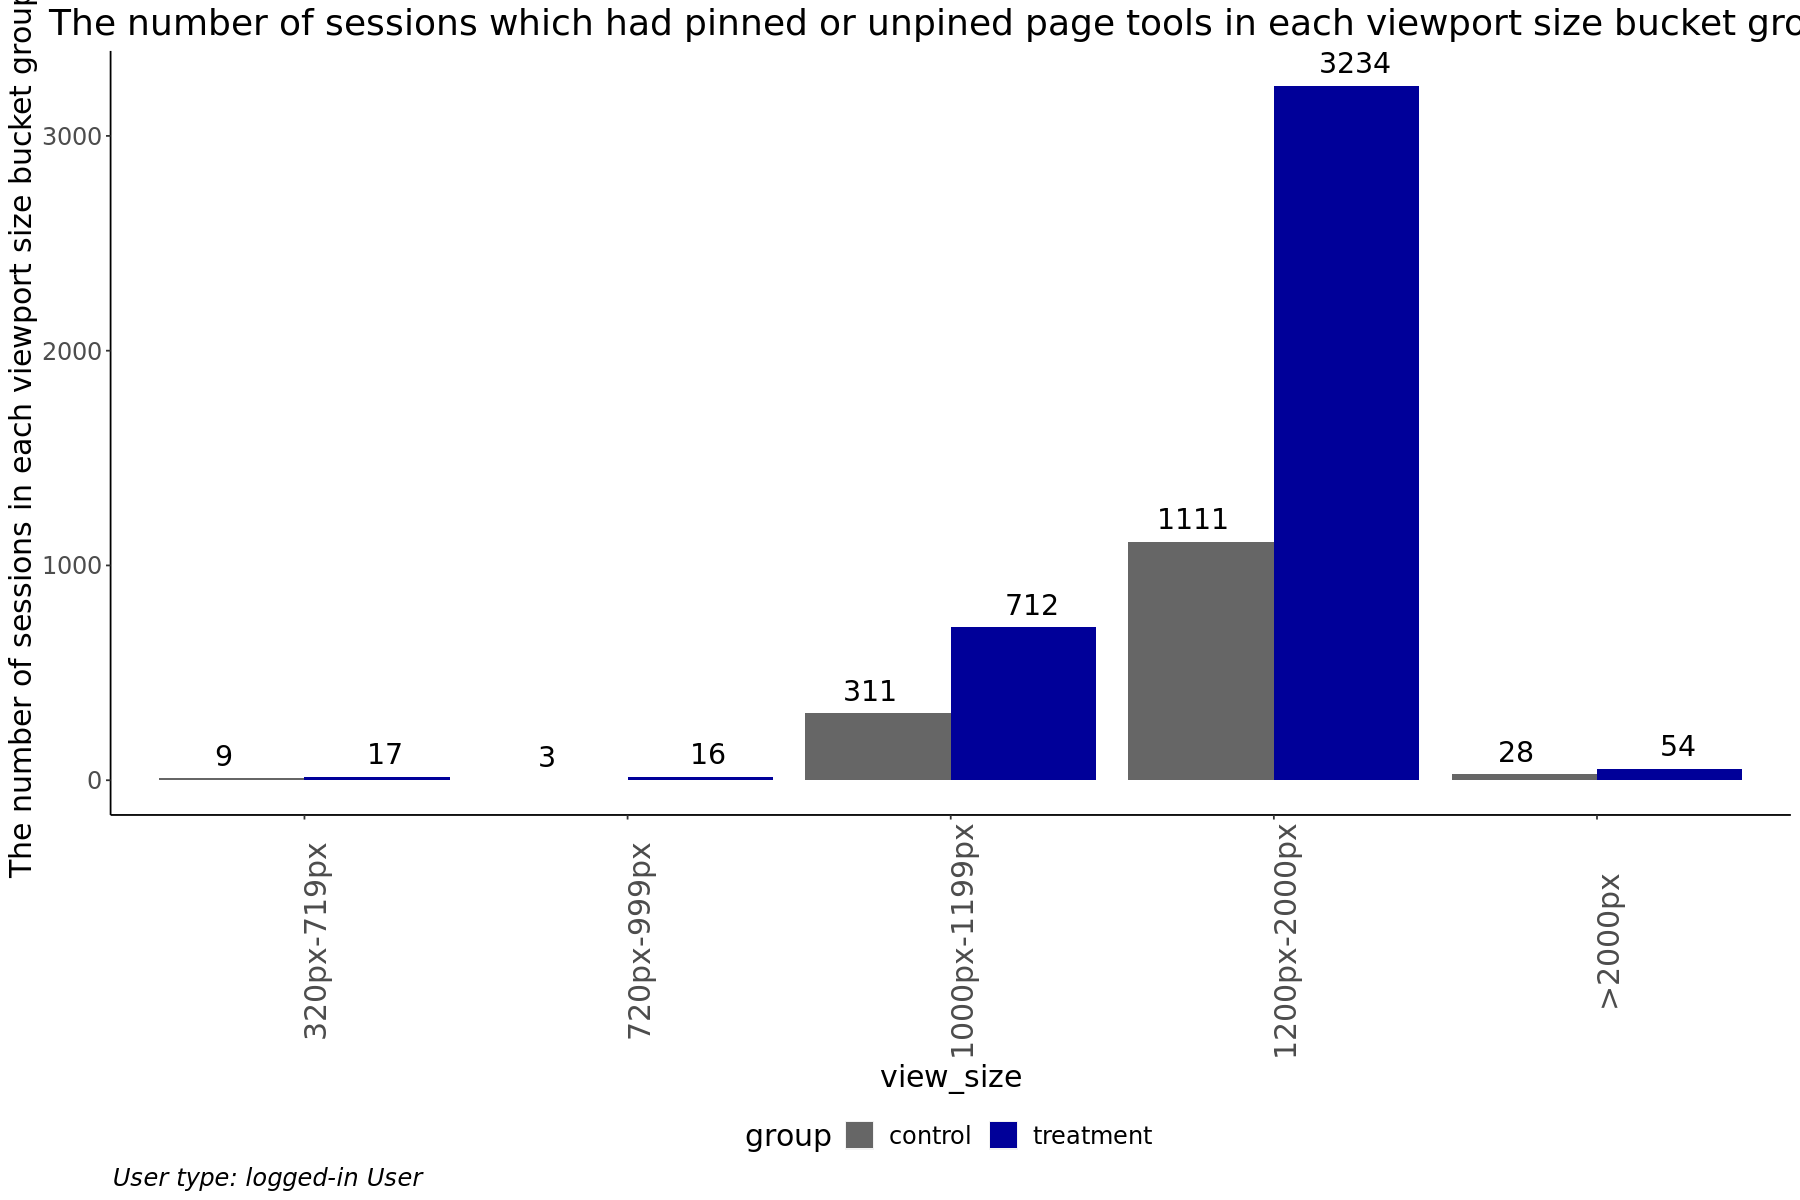

In [155]:
barchart_sessions_viewsizebucket_overall <- df_pt_click_viewsizebucket_overall  %>%
  ggplot(aes(x = view_size, y= n_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(n_sessions)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.6, hjust = 0.5, size = 6) +
        labs (
              y = "The number of sessions in each viewport size bucket group" ,
             title = "The number of sessions which had pinned or unpined page tools in each viewport size bucket group" ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_viewsizebucket_overall

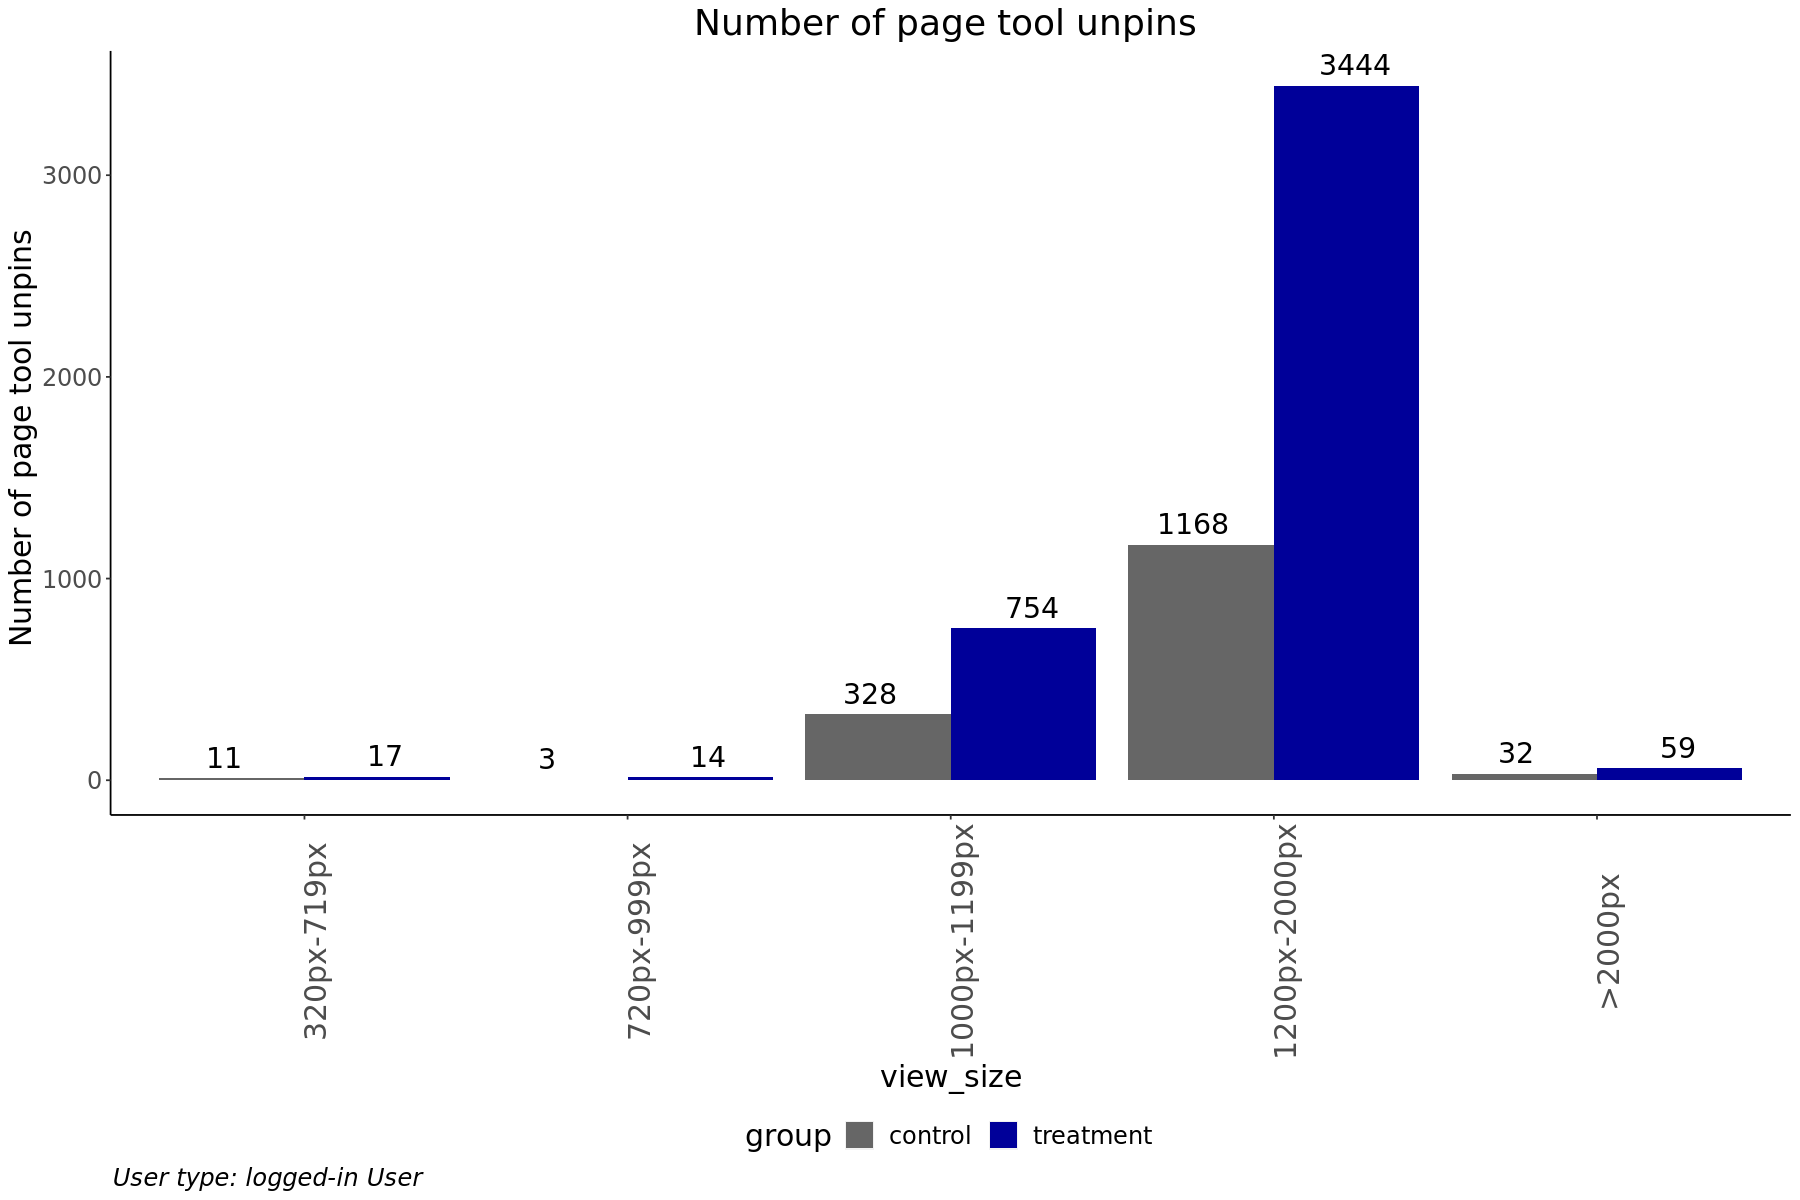

In [159]:
barchart_unpins_viewportsizebucket_overall  <- df_pt_click_viewsizebucket_overall  %>%
        select(view_size, test_group, total_unpins) %>%
        ggplot(aes(x = view_size, y= total_unpins, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_unpins)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        labs (
              y = "Number of page tool unpins " ,
             title = "Number of page tool unpins " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_unpins_viewportsizebucket_overall

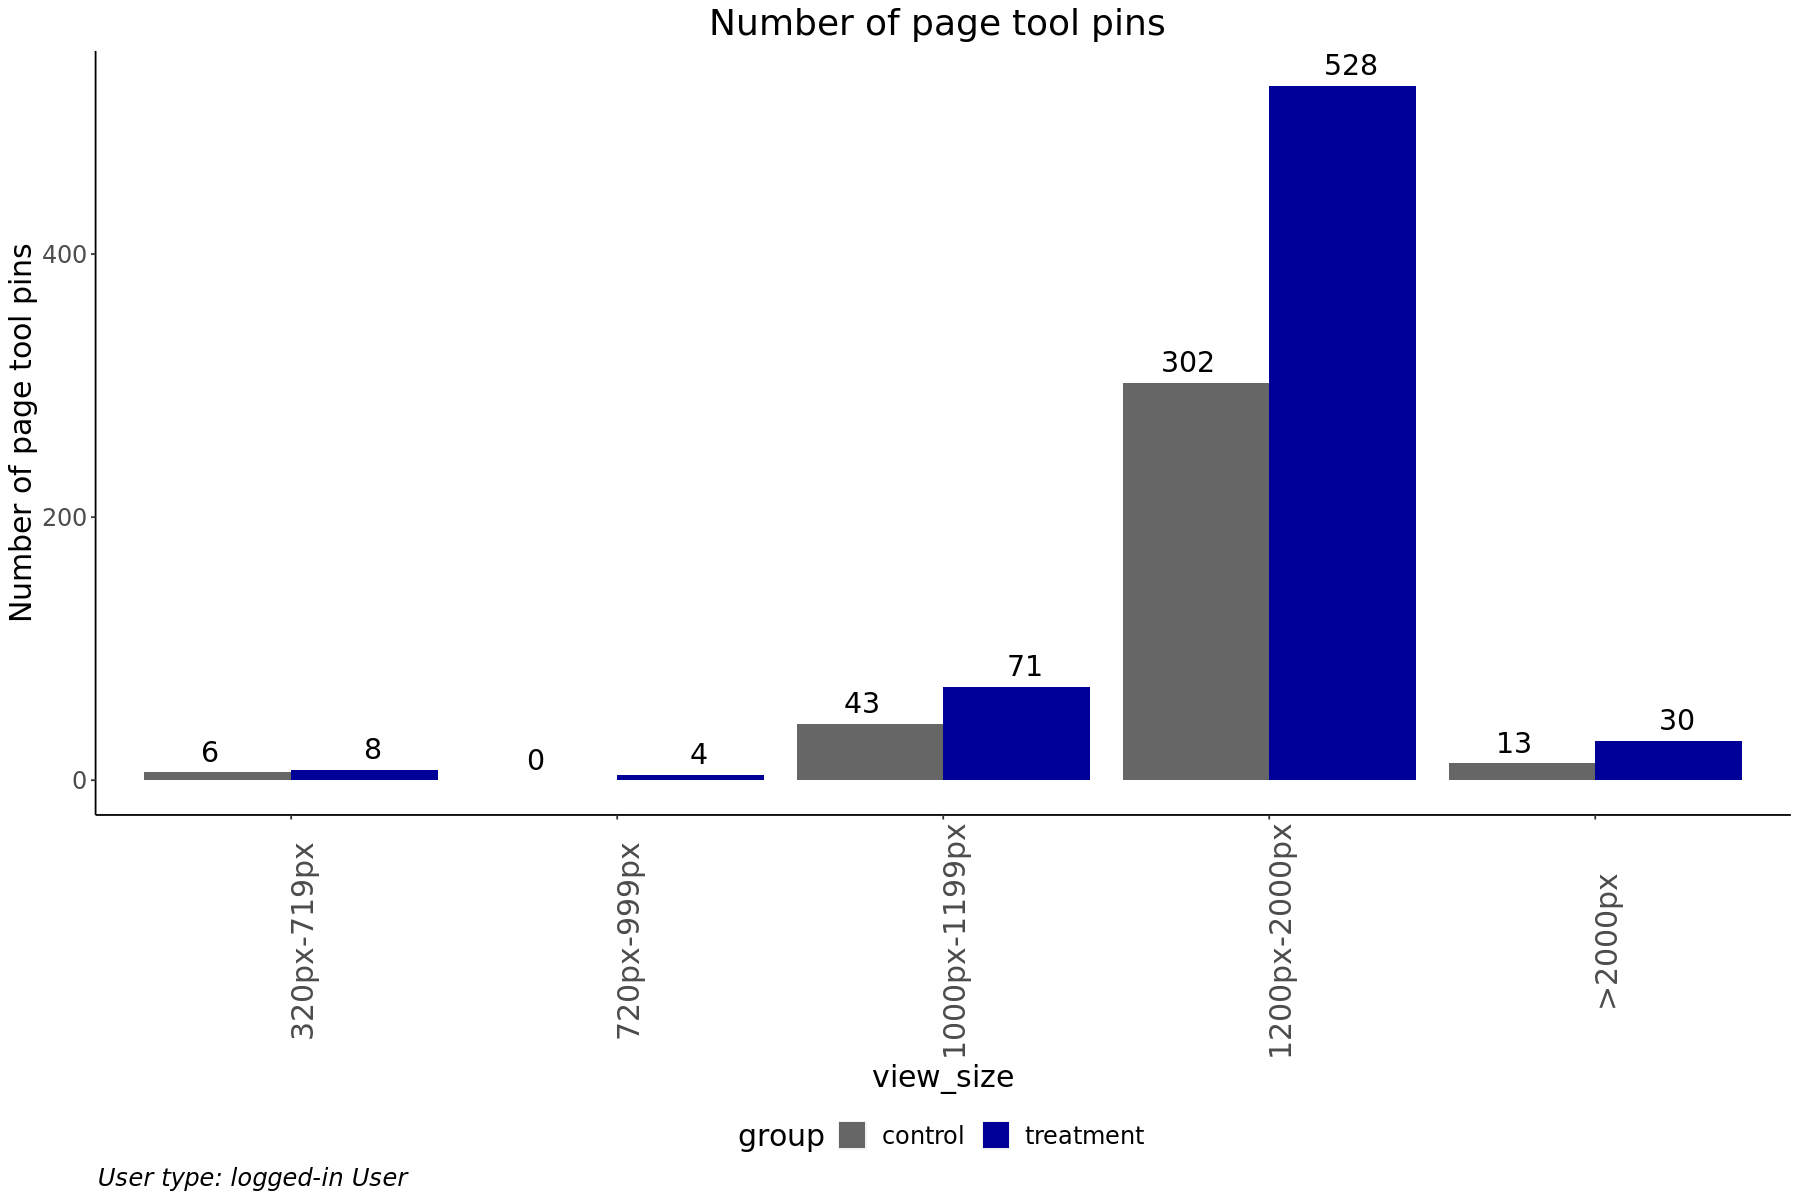

In [162]:
barchart_pins_viewportsizebucket_overall  <- df_pt_click_viewsizebucket_overall  %>%
        select(view_size, test_group, total_pins) %>%
        ggplot(aes(x = view_size, y=  total_pins, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste( total_pins)), color = "black", position = position_dodge(width = 1), 
                  vjust = -0.5, hjust = 0.5, size = 6) +
        labs (
              y = "Number of page tool pins" ,
             title = "Number of page tool pins " ,
             caption = "User type: logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "group")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_text(angle=90, size=18),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=18),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pins_viewportsizebucket_overall

### Note
 
Page tool pins and unpins increased across all viewport size buckets in the treatment group.